# **Imports**

In [1]:
import numpy as np
import pandas as pd
import os
import re
import warnings
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.preprocessing import minmax_scale

In [2]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

In [21]:
from sklearn.preprocessing import LabelEncoder

In [90]:
import seaborn as sns

In [91]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, InputLayer, UpSampling2D, Layer, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.utils import to_categorical
from numpy import argmax

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam, Adadelta, RMSprop
import keras.backend as K

# **Data Preprocessing**

In [ ]:
!unzip '/content/drive/MyDrive/Datasets/speech emotion dataset.zip' -d '/content/data'

In [ ]:
#finding the path of every wave file in the dataset!
records = []
for dirname, _, filenames in os.walk('/content/data'):
    for filename in filenames:
        records.append([filename, os.path.join(dirname,filename)])


records

In [5]:
data = pd.DataFrame(records, columns=['filename','path'])
data['actor'] = data['path'].apply(lambda x: re.findall("\w+_\d+",x)[0])
data = data[data['actor']!="audio_speech_actors_01"]
data.reset_index(inplace=True,drop=True)
data['type'] = data['filename'].apply(lambda x: re.split("-\d+\.wav",x)[0])
data

,filename,path,actor,type
0,03-01-06-01-02-02-15.wav,/content/data/Actor_15/03-01-06-01-02-02-15.wav,Actor_15,03-01-06-01-02-02
1,03-01-05-01-02-01-15.wav,/content/data/Actor_15/03-01-05-01-02-01-15.wav,Actor_15,03-01-05-01-02-01
2,03-01-06-01-01-01-15.wav,/content/data/Actor_15/03-01-06-01-01-01-15.wav,Actor_15,03-01-06-01-01-01
3,03-01-02-01-01-01-15.wav,/content/data/Actor_15/03-01-02-01-01-01-15.wav,Actor_15,03-01-02-01-01-01
4,03-01-03-02-01-01-15.wav,/content/data/Actor_15/03-01-03-02-01-01-15.wav,Actor_15,03-01-03-02-01-01
...,...,...,...,...
1435,03-01-05-02-01-01-12.wav,/content/data/Actor_12/03-01-05-02-01-01-12.wav,Actor_12,03-01-05-02-01-01
1436,03-01-01-01-01-01-12.wav,/content/data/Actor_12/03-01-01-01-01-01-12.wav,Actor_12,03-01-01-01-01-01
1437,03-01-05-01-02-01-12.wav,/content/data/Actor_12/03-01-05-01-02-01-12.wav,Actor_12,03-01-05-01-02-01
1438,03-01-08-02-02-01-12.wav,/content/data/Actor_12/03-01-08-02-02-01-12.wav,Actor_12,03-01-08-02-02-01


In [6]:
data['actor'].nunique()

24

In [7]:
data['actor'].value_counts()

Actor_15    60
Actor_24    60
Actor_09    60
Actor_22    60
Actor_10    60
Actor_23    60
Actor_21    60
Actor_11    60
Actor_02    60
Actor_04    60
Actor_13    60
Actor_16    60
Actor_19    60
Actor_07    60
Actor_20    60
Actor_03    60
Actor_18    60
Actor_01    60
Actor_17    60
Actor_08    60
Actor_14    60
Actor_06    60
Actor_05    60
Actor_12    60
Name: actor, dtype: int64

In [136]:
desired_waves = []
for Emotion in ["03", "04"]:
  # for Emotion in ["02", "03", "04", "05", "06", "07", "08"]:
    for intensity  in ["01", "02"]:
        for Statement in ["01", "02"]:
            for Repetition  in ["01", "02"]:
                desired_waves.append(f"03-01-{Emotion }-{intensity }-{Statement}-{Repetition }")
                
data = data[data['type'].isin(desired_waves)]
data.reset_index(inplace=True,drop=True)

In [137]:
# def get_clcass(x):
#   x_list = x.split('-')
#   return int(x_list[2])

def get_clcass(x):
  x_list = x.split('-')
  classn = int(x_list[2])
  if classn == 2 or classn == 3 or classn == 8:
    return 1
  return 0

In [138]:
def get_gender(x):
  x_list = x.split('_')
  return int(int(x_list[1]) % 2 == 0)

In [ ]:
data['class'] = data['type'].apply(get_clcass)
data['gender'] = data['actor'].apply(get_gender)

In [140]:
data

,filename,path,actor,type,class,gender
0,03-01-03-02-01-01-15.wav,/content/data/Actor_15/03-01-03-02-01-01-15.wav,Actor_15,03-01-03-02-01-01,1,0
1,03-01-03-01-02-01-15.wav,/content/data/Actor_15/03-01-03-01-02-01-15.wav,Actor_15,03-01-03-01-02-01,1,0
2,03-01-04-01-02-02-15.wav,/content/data/Actor_15/03-01-04-01-02-02-15.wav,Actor_15,03-01-04-01-02-02,0,0
3,03-01-04-01-02-01-15.wav,/content/data/Actor_15/03-01-04-01-02-01-15.wav,Actor_15,03-01-04-01-02-01,0,0
4,03-01-04-02-02-01-15.wav,/content/data/Actor_15/03-01-04-02-02-01-15.wav,Actor_15,03-01-04-02-02-01,0,0
...,...,...,...,...,...,...
379,03-01-03-02-02-01-12.wav,/content/data/Actor_12/03-01-03-02-02-01-12.wav,Actor_12,03-01-03-02-02-01,1,1
380,03-01-04-01-01-01-12.wav,/content/data/Actor_12/03-01-04-01-01-01-12.wav,Actor_12,03-01-04-01-01-01,0,1
381,03-01-04-02-01-02-12.wav,/content/data/Actor_12/03-01-04-02-01-02-12.wav,Actor_12,03-01-04-02-01-02,0,1
382,03-01-03-02-02-02-12.wav,/content/data/Actor_12/03-01-03-02-02-02-12.wav,Actor_12,03-01-03-02-02-02,1,1


In [141]:
data['gender'].value_counts()

0    192
1    192
Name: gender, dtype: int64

In [142]:
data['class'].value_counts()

1    192
0    192
Name: class, dtype: int64

In [143]:
def feature_extraction(df, n_mels=256, mfcc=True):
    features = []
    for i,record in tqdm(df.iterrows(),total=df.shape[0]):
        x , sr = librosa.load(record['path'])
        if mfcc:
          feature = np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc=n_mels),axis=1)
        else:
          feature = np.mean(librosa.feature.melspectrogram(y=x, sr=sr, n_mels=n_mels),axis=1)
        features.append(feature)
        
    dataf = pd.DataFrame(features)
    dataf['class'] = df['class']
    return dataf

In [144]:
dataf = feature_extraction(data)
dataf

100%|██████████| 384/384 [01:33<00:00,  4.12it/s]


,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,class
0,-534.011353,53.023712,-4.433788,20.436903,10.487662,2.970737,3.153078,6.918076,-2.723094,7.741090,...,0.140436,0.332654,0.135042,0.211539,0.528538,0.377186,-0.060424,0.126825,-0.101540,1
1,-607.296387,72.686317,-8.776737,16.474308,14.138918,1.489949,-1.819367,-0.006759,-3.948661,0.464627,...,0.455346,0.495445,0.597533,0.633138,0.735175,0.612393,0.329188,0.337153,0.373860,1
2,-624.809814,78.754044,-1.337214,18.033997,13.770799,2.538930,1.827972,-0.293346,-4.293371,4.200765,...,0.110658,0.098476,0.154398,0.370456,0.031360,0.097968,-0.174590,-0.438722,0.051951,0
3,-621.825012,64.829651,-2.207083,16.958910,13.353213,2.682176,1.021411,2.146424,-2.129469,3.262198,...,0.291308,0.292537,0.004907,-0.120288,0.240404,0.117328,-0.361489,-0.070461,0.755780,0
4,-596.351074,58.433403,-11.341997,14.086228,11.148762,-2.038445,-1.053091,-0.859459,-6.702956,4.734325,...,0.303794,-0.062610,0.036294,0.534838,0.604767,0.217123,-0.015460,-0.064745,-0.159319,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,-546.362427,42.639999,-20.593513,5.049128,-2.962460,-9.379161,-7.798457,-11.114220,-11.582814,2.590083,...,-0.440657,-0.453476,-0.167439,0.299562,-0.039913,-0.162639,0.324126,-0.092631,-0.272216,1
380,-624.428955,58.625443,-11.662168,6.876777,-0.556658,-5.448256,-7.119104,-10.308788,-11.914625,-0.986978,...,-0.231570,0.008706,0.297160,0.229709,-0.095319,0.056630,0.014940,-0.073966,-0.298488,0
381,-491.846832,41.157749,-28.990593,-5.180639,-9.814553,-15.862906,-11.737224,-15.351455,-14.212711,5.309237,...,0.080131,0.030080,-0.058324,0.234362,0.118876,-0.033933,-0.024959,-0.212345,-0.311496,0
382,-466.817596,31.821203,-31.982365,-5.055453,-6.710791,-16.952835,-9.907125,-10.349740,-14.323522,2.149804,...,0.327854,-0.030709,0.154281,0.446209,0.052221,0.048685,0.181452,-0.228793,0.097568,1


In [145]:
X = dataf.iloc[:,:-1].values
y = dataf.iloc[:,-1].values 

In [146]:
X.shape

(384, 128)

In [147]:
encoder = LabelEncoder()

In [148]:
y = encoder.fit_transform(y)

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# **Models**

## **LightGBM**

In [150]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

In [151]:
y_pred_lbg = clf.predict(X_test)

              precision    recall  f1-score   support

           0       0.88      0.72      0.79        39
           1       0.76      0.89      0.82        38

    accuracy                           0.81        77
   macro avg       0.82      0.81      0.80        77
weighted avg       0.82      0.81      0.80        77



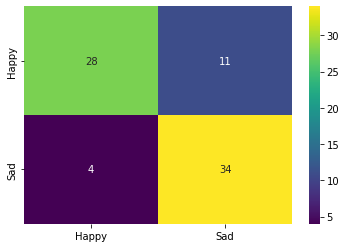

In [166]:
print(classification_report(y_test,y_pred_lbg))
cmatrix = confusion_matrix(y_test,y_pred_lbg)
sns.heatmap(cmatrix,annot=True,fmt='.3g',cmap='viridis',xticklabels=['Happy','Sad'],yticklabels=['Happy','Sad'])
plt.show()